In [1]:
# !pip install beautifulsoup4
# !python -m pip install statsmodels
# !python -m pip install lxml
# !python -m pip install html5lib
# !python -m pip install parser-libraries
# !python -m pip install --upgrade beautifulsoup4
# !python -m pip install ephem

from bs4 import BeautifulSoup
from urllib.request import urlopen
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
with urlopen('https://www.myhora.com/lottery/stats.aspx?mx=09&vx=30&rx=0') as response:
    urls = response.read()
    soup = BeautifulSoup(urls, 'html.parser')
    table = soup.select_one('#dl_lottery_stats_list')
    # print(table)
    
    rows = table.find_all('div', class_='rowx div-link')
    data = []

    for row in rows:
        cols = row.find_all('div', class_='colx')
        cols_text = [col.get_text(strip=True) for col in cols]
        data.append(cols_text)

    df = pd.DataFrame(data)
    print(df)

     0           1      2     3   4       5   6    7   8                9   \
0    16      เมษายน  เม.ย.  2568  68  266227  27  227  85    254413474 760   
1     1      เมษายน  เม.ย.  2568  68  669687  87  687  36    635760180 666   
2    16      มีนาคม  มี.ค.  2568  68  757563  63  563  32    595927309 457   
3     1      มีนาคม  มี.ค.  2568  68  818894  94  894  54    139530656 781   
4    16  กุมภาพันธ์   ก.พ.  2568  68  847377  77  377  50    268613001 652   
..   ..         ...    ...   ...  ..     ...  ..  ...  ..              ...   
715  17     พฤษภาคม   พ.ค.  2538  38  220381  81  381  55  460 597 511 488   
716   2     พฤษภาคม   พ.ค.  2538  38  504692  92  692  88  304 886 268 273   
717  16      เมษายน  เม.ย.  2538  38  053581  81  581  99  560 968 681 376   
718   1      เมษายน  เม.ย.  2538  38  427039  39  039  06  254 926 674 978   
719  16      มีนาคม  มี.ค.  2538  38  646847  47  847  67  225 044 091 220   

     10               11  
0    85    254413474 760  
1    36  

In [3]:
df = df.drop(columns=[2, 4, 10, 11])
print(df.head())

    0           1     3       5   6    7   8              9
0  16      เมษายน  2568  266227  27  227  85  254413474 760
1   1      เมษายน  2568  669687  87  687  36  635760180 666
2  16      มีนาคม  2568  757563  63  563  32  595927309 457
3   1      มีนาคม  2568  818894  94  894  54  139530656 781
4  16  กุมภาพันธ์  2568  847377  77  377  50  268613001 652


In [4]:
df.columns = ['วัน', 'เดือน', 'ปี', 'รางวัลที่หนึ่ง', '2ตัวบน', '3ตัวบน', '2ตัวล่าง', '3ตัวหน้า-3ตัวล่าง']

df['ปี'] = df['ปี'].astype(int) - 543

thai_months = {
    'มกราคม': 1, 'กุมภาพันธ์': 2, 'มีนาคม': 3, 'เมษายน': 4, 'พฤษภาคม': 5, 
    'มิถุนายน': 6, 'กรกฎาคม': 7, 'สิงหาคม': 8, 'กันยายน': 9, 
    'ตุลาคม': 10, 'พฤศจิกายน': 11, 'ธันวาคม': 12
}

df['เดือน'] = df['เดือน'].map(thai_months)

df['3ตัวหน้า-3ตัวล่าง'] = df['3ตัวหน้า-3ตัวล่าง'].str.replace(' ', '')
df[['3ตัวหน้า-1', '3ตัวล่าง-2', '3ตัวบน-1', '3ตัวบน-2']] = df['3ตัวหน้า-3ตัวล่าง'].str.extract(r'(\d{3})(\d{3})(\d{3})(\d{3})')
df['3ตัวหน้า-3ตัวล่าง'] = df['3ตัวหน้า-3ตัวล่าง'].apply(lambda x: ' '.join([x[i:i+3] for i in range(0, len(x), 3)]))
print(df.head())
# Save the DataFrame to a CSV file
df.to_csv('lottery_data.csv', index=False)

  วัน  เดือน    ปี รางวัลที่หนึ่ง 2ตัวบน 3ตัวบน 2ตัวล่าง 3ตัวหน้า-3ตัวล่าง  \
0  16      4  2025         266227     27    227       85   254 413 474 760   
1   1      4  2025         669687     87    687       36   635 760 180 666   
2  16      3  2025         757563     63    563       32   595 927 309 457   
3   1      3  2025         818894     94    894       54   139 530 656 781   
4  16      2  2025         847377     77    377       50   268 613 001 652   

  3ตัวหน้า-1 3ตัวล่าง-2 3ตัวบน-1 3ตัวบน-2  
0        254        413      474      760  
1        635        760      180      666  
2        595        927      309      457  
3        139        530      656      781  
4        268        613      001      652  


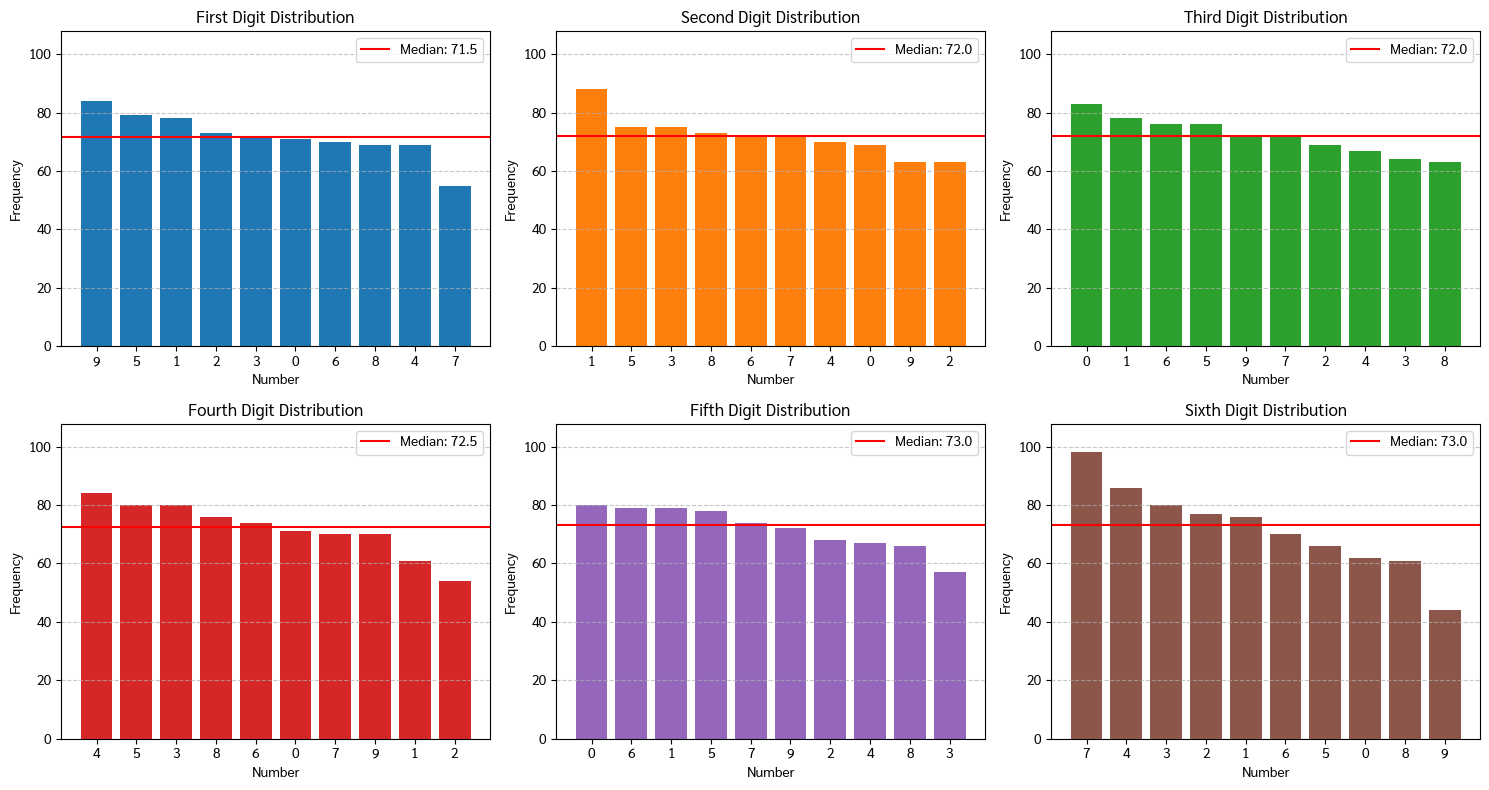

In [160]:
# Extract each digit of the first prize number
df['รางวัลที่หนึ่ง'] = df['รางวัลที่หนึ่ง'].astype(str).str.zfill(6)  # Ensure 6 digits with leading zeros

plt.figure(figsize=(15, 8))
positions = [(0, 'First'), (1, 'Second'), (2, 'Third'), (3, 'Fourth'), (4, 'Fifth'), (5, 'Sixth')]

for i, (pos, label) in enumerate(positions):
    plt.subplot(2, 3, i+1)
    
    digit_var_name = f'win_digit{i+1}'
    globals()[digit_var_name] = df['รางวัลที่หนึ่ง'].str[pos]
    
    digit_counts = globals()[digit_var_name].value_counts()
    
    plt.bar(digit_counts.index, digit_counts.values, color=plt.cm.tab10(i))
    median_value = digit_counts.median()
    plt.axhline(y=median_value, color='r', linestyle='-', label=f'Median: {median_value}')
    plt.legend(loc='upper right')
    plt.title(f'{label} Digit Distribution')
    plt.xlabel('Number')
    plt.ylabel('Frequency')
    plt.xticks(range(10))
    # Get the maximum frequency across all digits for consistent y-axis scale
    max_frequency = max(df['รางวัลที่หนึ่ง'].str[pos].value_counts().max() for pos in range(6))
    plt.ylim(0, max_frequency * 1.1)  # Add 10% padding at the top
    # plt.xticks(range(10), [str(i) for i in range(10)])
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

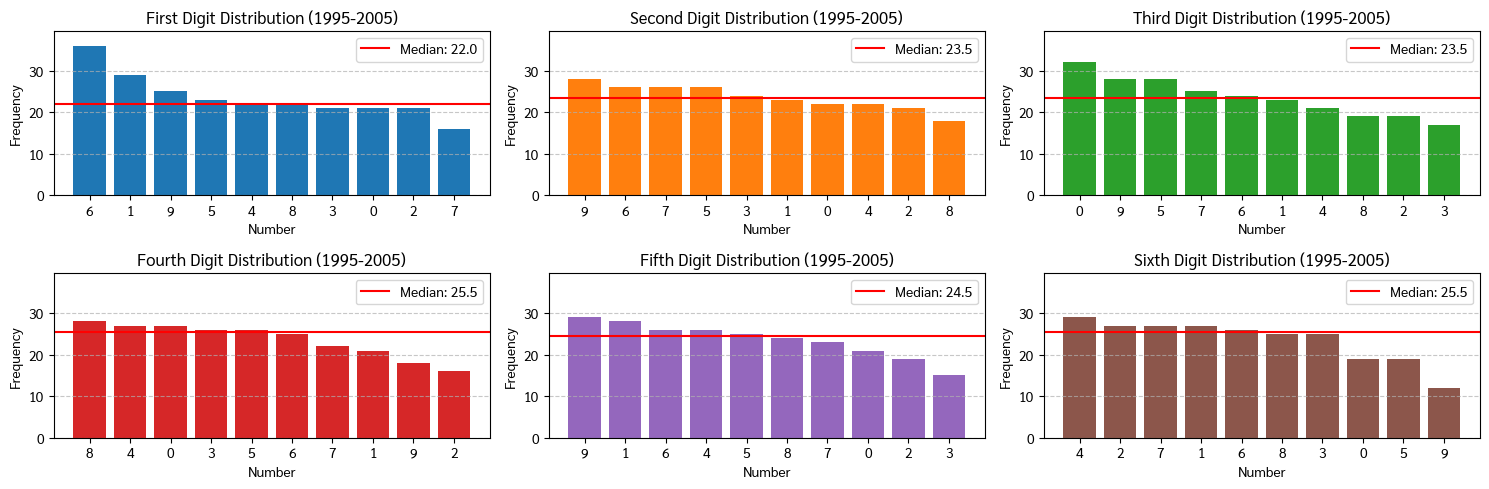

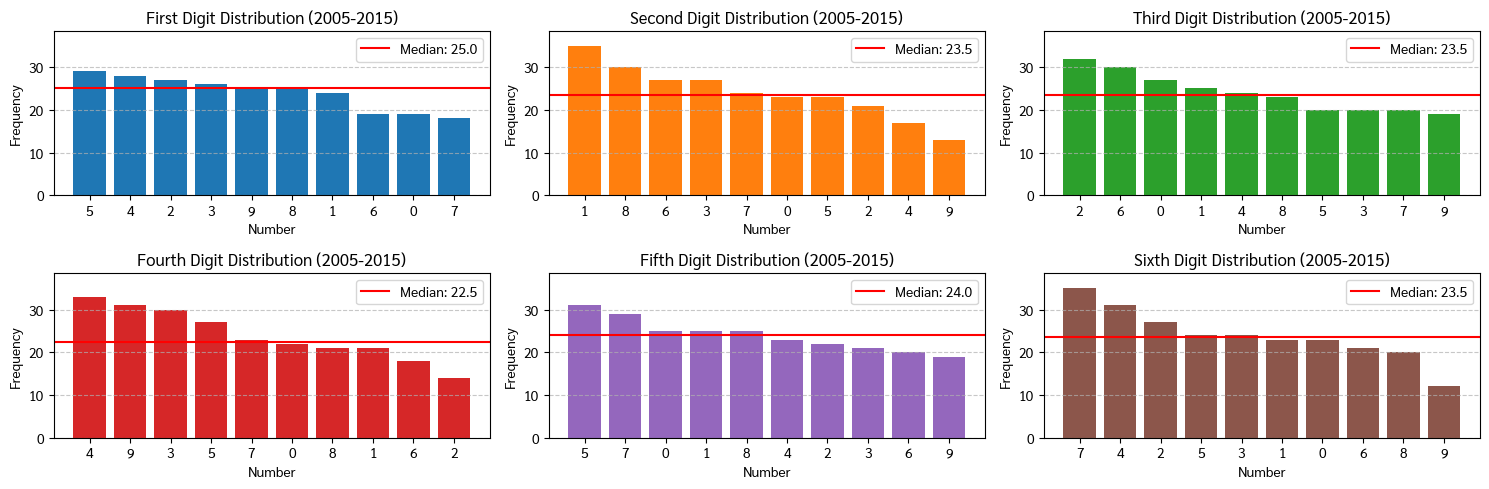

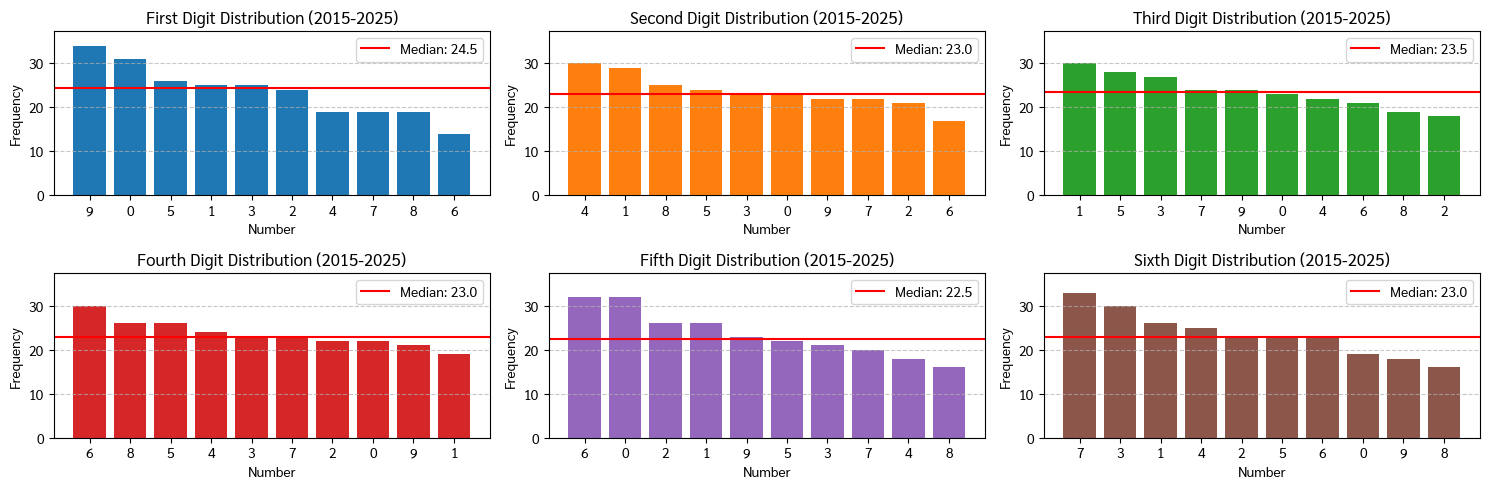

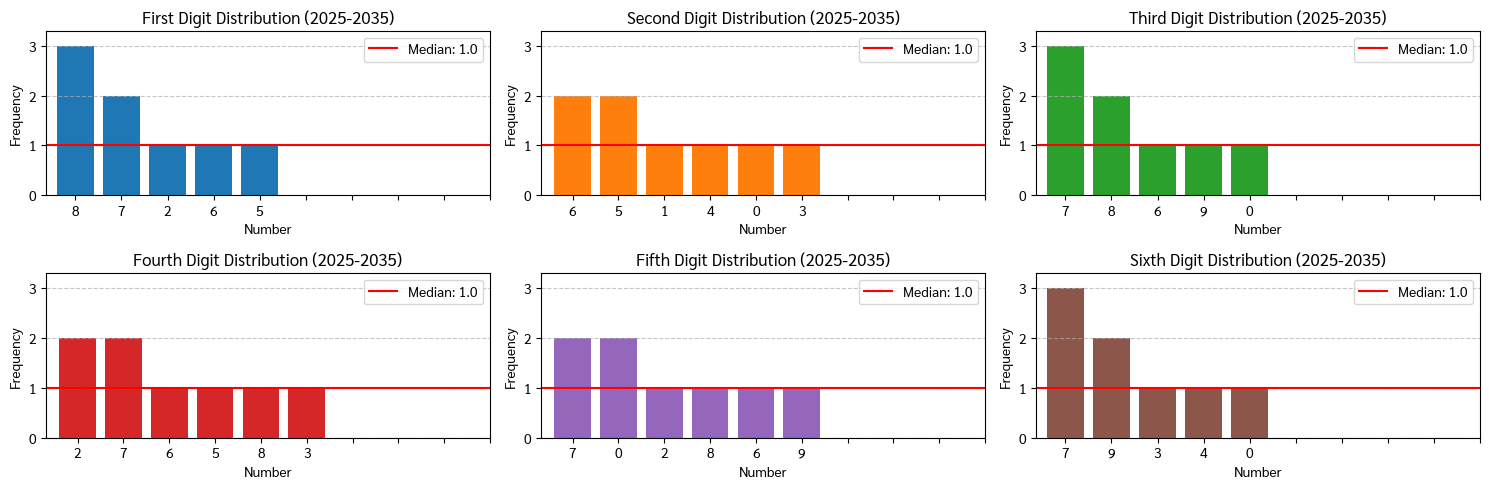

In [195]:
years = []

filtered_df = df.copy()

every_Xyear = 10

for i in range(0, (filtered_df['ปี'].max() - filtered_df['ปี'].min()) // every_Xyear + 1):
    years.append(filtered_df['ปี'].min() + every_Xyear*i) 

for year in years:
    plt.figure(figsize=(15, 5))
    filtered_df_year = filtered_df[(filtered_df['ปี'] >= year) & (filtered_df['ปี'] < year + every_Xyear)]
    for i, (pos, label) in enumerate(positions):
        plt.subplot(2, 3, i+1)
        
        digit_var_name = f'win_digit{i+1}'
        globals()[digit_var_name] = filtered_df_year['รางวัลที่หนึ่ง'].str[pos]
        
        digit_counts = globals()[digit_var_name].value_counts()
        
        # print(f'Year: {year}, Position: {pos}, Digit Counts: {digit_counts}')
        
        plt.bar(digit_counts.index, digit_counts.values, color=plt.cm.tab10(i))
        plt.title(f'{label} Digit Distribution ({year}-{year + every_Xyear})')
        plt.xlabel('Number')
        plt.ylabel('Frequency')
        
        max_frequency = max(filtered_df_year['รางวัลที่หนึ่ง'].str[pos].value_counts().max() for pos in range(6))
        
        plt.ylim(0, max_frequency * 1.1)  # Add 10% padding at the top
        plt.axhline(y=digit_counts.median(), color='r', linestyle='-', label=f'Median: {digit_counts.median()}')
        plt.legend(loc='upper right')
        plt.xticks(range(10))
        
        plt.title(f'{label} Digit Distribution ({year}-{year + every_Xyear})')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



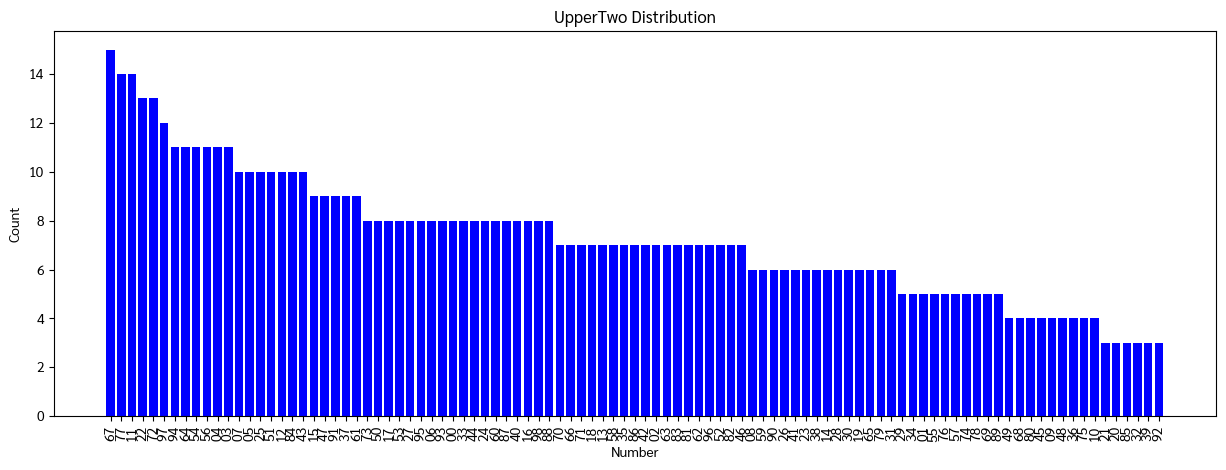

In [80]:
upper2 = df['2ตัวบน']

upper2.value_counts()
plt.figure(figsize=(15, 5))
plt.bar(upper2.value_counts().index, upper2.value_counts().values, color='blue')
plt.title('UpperTwo Distribution')
plt.xlabel('Number')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

    2ตัวบน 3ตัวบน เลขแรก 3 ตัวบน
0       27    227              2
1       87    687              6
2       63    563              5
3       94    894              8
4       77    377              3
..     ...    ...            ...
715     81    381              3
716     92    692              6
717     81    581              5
718     39    039              0
719     47    847              8

[720 rows x 3 columns]


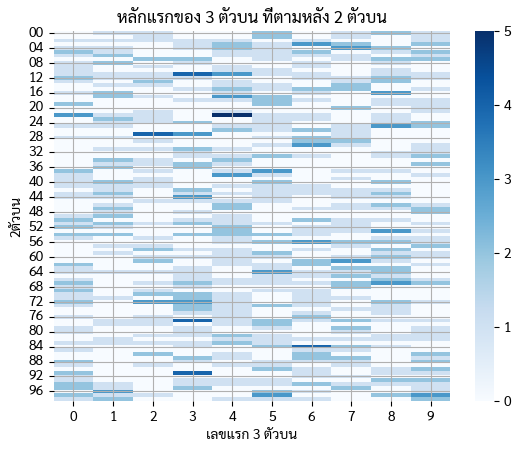

In [ ]:
import matplotlib
from matplotlib import font_manager

thai_font_path = font_manager.fontManager.addfont(r"C:\Users\jjban\AppData\Local\Microsoft\Windows\Fonts\Sarabun-Regular.ttf")

matplotlib.rcParams['font.family'] = 'Sarabun'

filtered_df = df.copy()
								  
filtered_df['เลขแรก 3 ตัวบน'] = filtered_df['3ตัวบน'].str[0]

print(filtered_df[['2ตัวบน', '3ตัวบน', 'เลขแรก 3 ตัวบน']])

plt.title('หลักแรกของ 3 ตัวบน ที่ตามหลัง 2 ตัวบน')
plt.xlabel('2ตัวบน')
plt.ylabel('หลักแรกของ 3ตัวบน')
plt.grid()

heatmap_data = pd.crosstab(filtered_df['2ตัวบน'], filtered_df['เลขแรก 3 ตัวบน'])

sns.heatmap(heatmap_data, fmt='d', cmap='Blues')
plt.show()

0      2
1      6
2      7
3      8
4      8
      ..
715    2
716    5
717    0
718    4
719    6
Name: win_digit1, Length: 720, dtype: object
0      6
1      6
2      5
3      1
4      4
      ..
715    2
716    0
717    5
718    2
719    4
Name: win_digit2, Length: 720, dtype: object
0      6
1      9
2      7
3      8
4      7
      ..
715    0
716    4
717    3
718    7
719    6
Name: win_digit3, Length: 720, dtype: object
0      2
1      6
2      5
3      8
4      3
      ..
715    3
716    6
717    5
718    0
719    8
Name: win_digit4, Length: 720, dtype: object
0      2
1      8
2      6
3      9
4      7
      ..
715    8
716    9
717    8
718    3
719    4
Name: win_digit5, Length: 720, dtype: object
0      7
1      7
2      3
3      4
4      7
      ..
715    1
716    2
717    1
718    9
719    7
Name: win_digit6, Length: 720, dtype: object


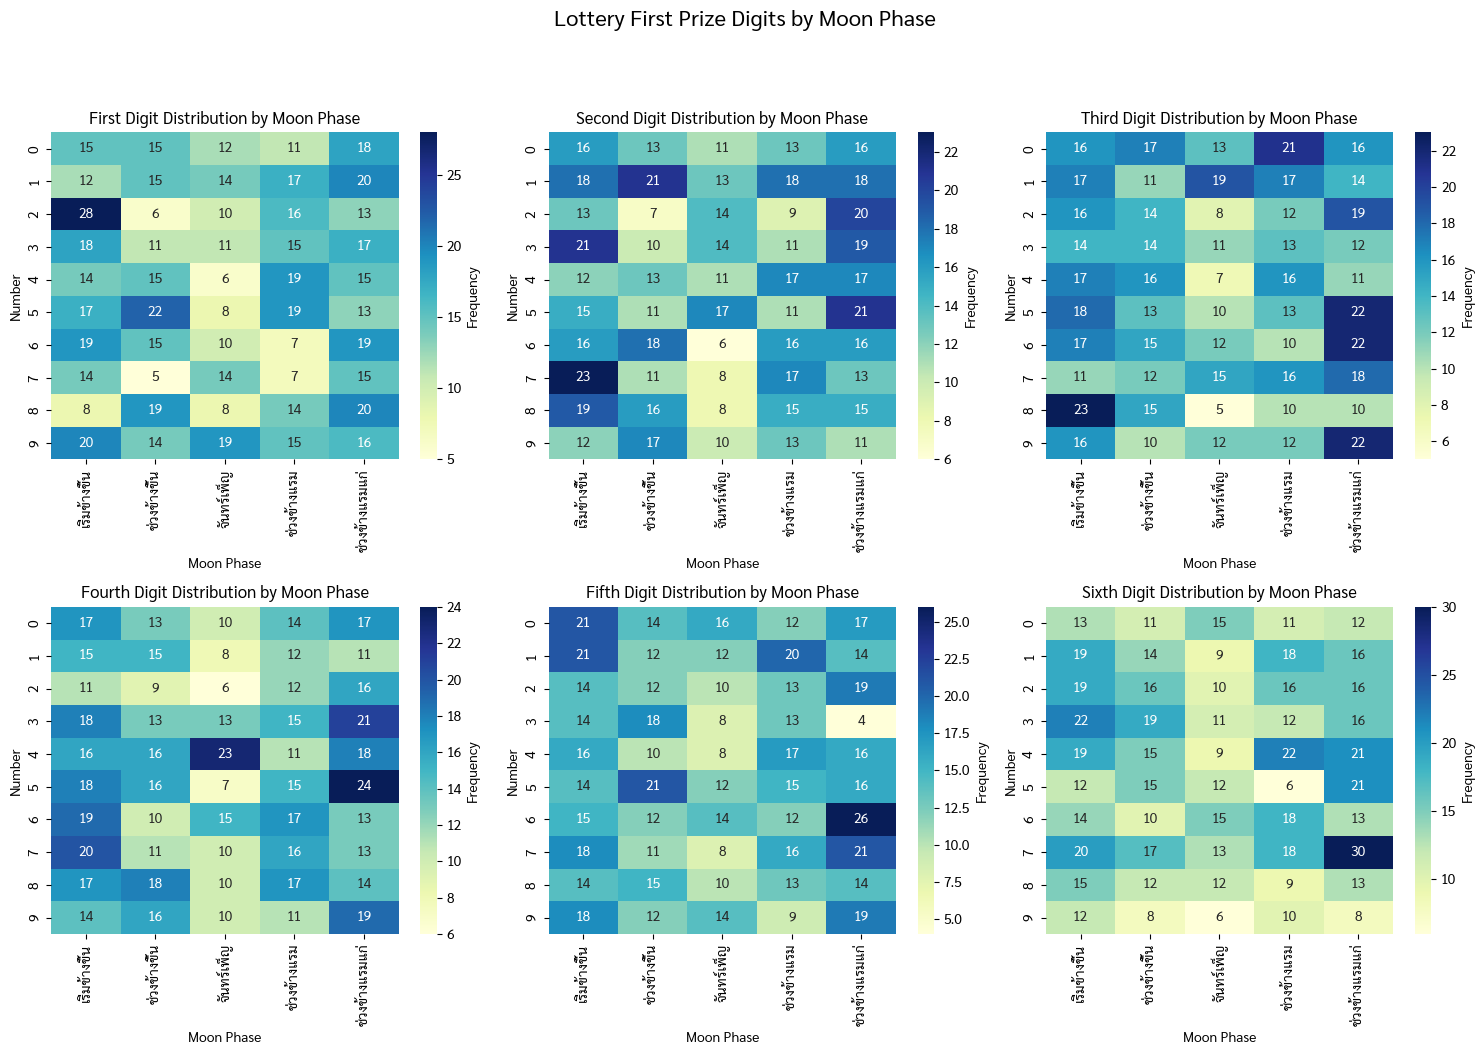

In [196]:
import ephem
from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt

# Function to calculate moon phase (0-1 where 0=new moon, 0.5=full moon, 1=new moon again)
def get_moon_phase(year, month, day):
    moon = ephem.Moon()
    # Convert the date to a DateTime object
    date = ephem.Date(datetime(year, month, day))
    moon.compute(date)
    # Moon phase is a value between 0 and 1
    return moon.phase / 100.0  # Normalized to 0-1 scale

# Ensure we have the digit columns in the dataframe
for i, (pos, label) in enumerate(positions):
    df[f'win_digit{i+1}'] = df['รางวัลที่หนึ่ง'].str[pos]
    print(df[f'win_digit{i+1}'])

# Add moon phase to our dataframe
df['moon_phase'] = df.apply(lambda row: get_moon_phase(int(row['ปี']), int(row['เดือน']), int(row['วัน'])), axis=1)

# Create moon phase categories for easier visualization
df['moon_category'] = pd.cut(df['moon_phase'], 
                            bins=[0, 0.125, 0.375, 0.625, 0.875, 1.0],
                            labels=['เริ่มข้างขึ้น', 'ช่วงข้างขึ้น', 'จันทร์เพ็ญ', 'ช่วงข้างแรม', 'ช่วงข้างแรมแก่'])

# Plot the distribution of first prize digits by moon phase
plt.figure(figsize=(15, 10))

# For each digit position
for i, (pos, label) in enumerate(positions):
    plt.subplot(2, 3, i+1)
    
    # Create a pivot table to show frequency of each digit by moon phase
    pivot = pd.crosstab(df[f'win_digit{i+1}'], df['moon_category'])
    
    # Plot as a heatmap
    sns.heatmap(pivot, cmap="YlGnBu", annot=True, fmt='.0f', cbar_kws={'label': 'Frequency'})
    
    plt.title(f'{label} Digit Distribution by Moon Phase')
    plt.xlabel('Moon Phase')
    plt.ylabel('Number')
    plt.tight_layout()

plt.suptitle('Lottery First Prize Digits by Moon Phase', fontsize=16, y=1.05)
plt.tight_layout()
    

     ปี  เดือน วัน  moon_distance_km
0  2025      4  16            400000
1  2025      4   1            360000
2  2025      3  16            400000
3  2025      3   1            360000
4  2025      2  16            400000


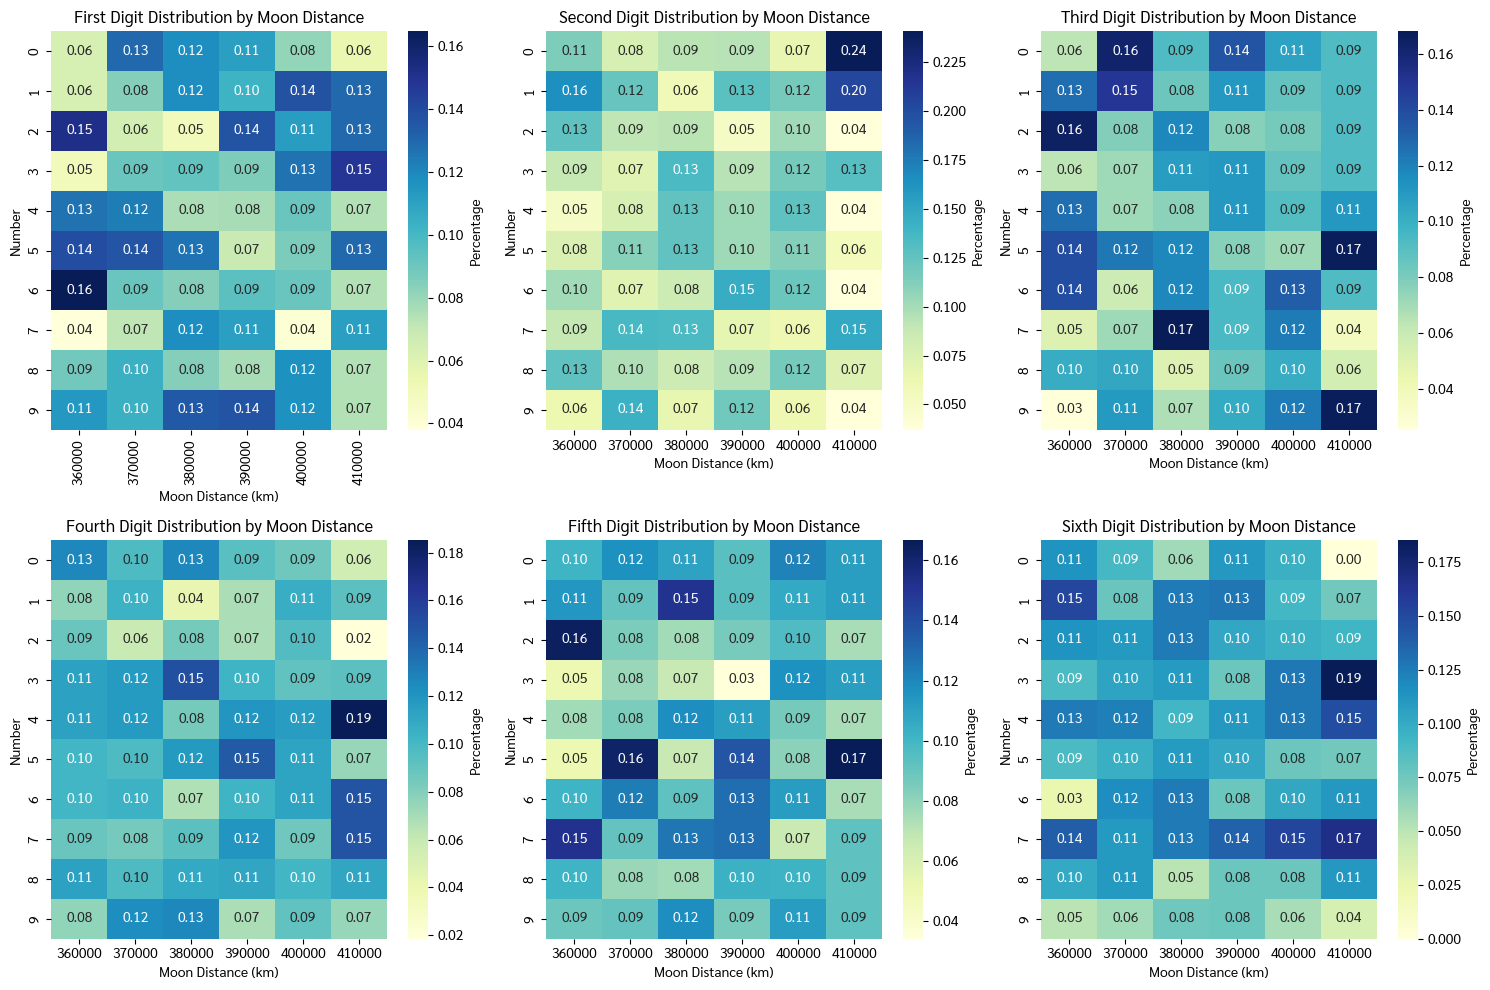

In [206]:
# Function to calculate the distance from Earth to the Moon
def get_moon_distance(year, month, day):
    moon = ephem.Moon()
    date = ephem.Date(datetime(year, month, day))
    moon.compute(date)
    au = ephem.meters_per_au
    return moon.earth_distance * au / 1000  # Convert to km

# Add moon distance to our dataframe
df['moon_distance_km'] = df.apply(lambda row: round(get_moon_distance(int(row['ปี']), int(row['เดือน']), int(row['วัน'])) / 10000) * 10000, axis=1)

print(df[['ปี', 'เดือน', 'วัน', 'moon_distance_km']].head())

plt.figure(figsize=(15, 10))

for i, (pos, label) in enumerate(positions):
    plt.subplot(2, 3, i+1)
    # Create a pivot table but normalize each column to show percentages
    pivot_data = df.pivot_table(index=f'win_digit{i+1}', columns='moon_distance_km', values='รางวัลที่หนึ่ง', aggfunc='count', fill_value=0)
    # Normalize the data (each column will sum to 1)
    normalized_pivot = pivot_data.div(pivot_data.sum(axis=0), axis=1)
    sns.heatmap(normalized_pivot, cmap="YlGnBu", annot=True, fmt='.2f', cbar_kws={'label': 'Percentage'})
    
    plt.title(f'{label} Digit Distribution by Moon Distance')
    plt.xlabel('Moon Distance (km)')
    plt.ylabel('Number')
    plt.tight_layout()
    